[View in Colaboratory](https://colab.research.google.com/github/rahutchinson/StudentLoanPaymentSandbox/blob/master/StudnetLoanPaymentCalculator.ipynb)

# Student Loan Most Efficient Pay Off Schedule

####Paying off highest rate **VS** Paying off highest daily cost

#####Background
This project was motivated by many people saying that the best possible way to pay off debt is the throw all you can at the highest interest rate that you have. Here is the mathmatical proof that although that is true most of the time, it is not always. 

#####Algorithms
The solution that I found that saved me $12 was to throw all your money at the debt that is costing you the most per day. So the intrest rate/365 * principal. You can see all of this below. 

# Setup


You need the basics. 

In [0]:
import pandas as pd
import numpy as np
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
PAYMENT_TIME = 30

#Debt Group Definition

In [0]:
class Group:
  def __init__(self, group_name,group_rate,group_princp, _active, _min_pay):
    self.name = group_name
    self.rate = group_rate
    self.active = _active
    self.daily_rate = group_rate/365
    self.principal = group_princp
    self.history = pd.DataFrame(index=range(0,730), columns=['Principal', 'Day Cost'])
    self.day = 0
    self.min_pay = _min_pay
    self.payments = []
    self.done = 0
    
  def add_daily_interest(self):
    if(self.active):
      self.principal = round((self.principal + (self.principal * self.daily_rate)),2)
    
  def pay_min(self):
    self.principal = self.principal - self.min_pay
    return self.min_pay
  def record(self):
    self.add_daily_interest()
    self.history.iat[self.day, 0]=self.principal
    self.history.iat[self.day, 1]=self.per_day_cost()
    if(self.principal == 0 and self.done == 0):
      self.done = self.day
      self.principal = 0
      self.rate = 0
    self.day = self.day + 1
     
  def payment(self, amount):
    if(amount > self.principal):
      amount = amount-self.principal
      self.payments.append([self.day, self.principal])
      self.principal = 0
      return amount
    else:
      self.principal = self.principal - amount
      self.payments.append([self.day, amount])
      return 0
    
  def per_day_cost(self):
    if(self.active):
      return self.principal * self.daily_rate
    return 0

# Payment Exploration & Results


552.9300000000003
B: 465
D: 434
E: 496
G: 496


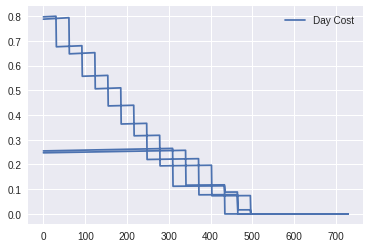

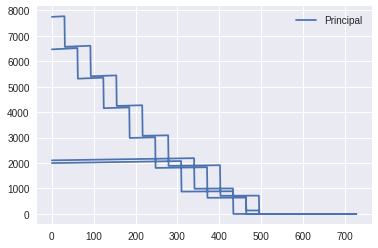

In [4]:
#@title High Rate or High Cost
High_Rate = False #@param {type:"boolean"}

#True = high rate model
#False = high daily cost model


RATE = False

def payment_exp_1(Groups, mon_payment,rate):
  #find hightest daily cost
  high_cost = max(group.per_day_cost() for group in Groups)
  high_cost_group = None
  for group in Groups:
    if(group.per_day_cost() == high_cost):
      high_cost_group = group
      break
      
  #find hightest interest rate
  high_rate_group_rate = max(group.rate for group in Groups)
  high_rate_group = None
  for group in Groups:
    if(group.rate == high_rate_group_rate):
      high_rate_group = group
      break
  left_over = 0
  if(rate):
    left_over = high_rate_group.payment(mon_payment)
  else:
    left_over = high_cost_group.payment(mon_payment)
  #print(high_cost_group.name + ": " + str(high_cost_group.principal))
  return round(left_over,2)

A = Group("A", .0466, 3400.00, False,0)
B = Group("B", .0466, 1996.08, True,0)
C = Group("C", .0429, 5500.00, False, 0)
D = Group("D", .0429, 2103.66, True,0)
E = Group("E", .0376, 7739.26, True,0)
G = Group("G", .0445, 7662.62, True,0)


groups = [B,D,E,G]
total_principal = 0

# Total Principal
for group in groups:
  total_principal += round(group.principal,2)

# Main Munch
month_watch = 0
for i in range(1,730):
  leftover = 0
  if(month_watch == 0):
    leftover = payment_exp_1(groups,1200,High_Rate)
    if(leftover != 0):
      payment_exp_1(groups,leftover, High_Rate)
    for group in groups:
      group.record()
    month_watch = PAYMENT_TIME
  else:
    for group in groups:
      group.record()
    month_watch -=1

histories = [B.history,D.history,E.history,G.history]
plt.figure()
concated = pd.concat(histories)

concated.plot(y='Day Cost')
concated.plot(y='Principal')
total = 0
for group in groups:
  for payment in group.payments:
    total += payment[1]
print(total-total_principal)
print("B: " + str(B.done))
print("D: " + str(D.done))
print("E: " + str(E.done))
print("G: " + str(G.done))